# AT&T Spams detector

## Loading the data and libraries

In [4]:
# librairies usuelles
import pandas as pd
import numpy as np
import plotly.express as px
# librairies qui vont servir lors du preprocessing textuel
import datetime
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

# librairies pour nos modèles : Tensorflow et Transformers de Hugging Face (pour les modèles pré-entraînés)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# classes et méthodes de Scikit-Learn pour le préprocessing, le splitting, les métriques, etc...
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# On importe également les plugings params pour Tensorboard, pour le tracking des performances de nos modèles
from tensorboard.plugins.hparams import api as hp
import warnings
warnings.filterwarnings('ignore')

In [5]:
# import vocabulary package
# Charger le modèle de langue anglais
!python -m spacy download en_core_web_md


2023-12-15 08:16:46.832462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 08:16:46.832565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 08:16:46.834319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 08:16:48.360383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [6]:
# Load dataset

data = pd.read_csv('./spam.csv', encoding = 'ISO-8859-1')
print(data.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [7]:

# Compter le nombre de valeurs NaN pour chaque colonne
nan_counts = data.isna().sum()

print("Nombre de valeurs NaN par colonne :")
print(nan_counts)

Nombre de valeurs NaN par colonne :
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [8]:
# Supprimer les colonnes qui contiennent plus de 50% de valeurs NaN

data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
print(data.head())
print(data.shape)

print("\n Nombre de hams et de span: \n", data['v1'].value_counts())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)

 Nombre de hams et de span: 
 ham     4825
spam     747
Name: v1, dtype: int64


# Preprocessing

## Nettoyage du texte

In [9]:
# remove poncutuations and convert to lower cases

data['v2_clean'] = data['v2'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())
data.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


## Lemmatisation et tokenisation

In [10]:
# lemmatize
nlp = spacy.load('en_core_web_md')
data["v2_lemma"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
data.head()


,v1,v2,v2_clean,v2_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live


In [11]:
## tokenisation

# Créer un objet Tokenizer avec un vocabulaire maximal de 2000 mots et un token "out_of_vocab" pour les mots hors vocabulaire
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab")

# Adapter le tokenizer aux textes de la colonne 'v2_lemma' de la variable 'data'
tokenizer.fit_on_texts(data['v2_lemma'])

# Obtenir la taille du vocabulaire (nombre de mots) basée sur le nombre maximal de mots spécifié
vocab_size = tokenizer.num_words
print(vocab_size)
# afficher le mapping entre les indices et les mots du vocabulaire construits à partir de la colonne 'v2_lemma'
# Transformer les textes de la colonne 'v2_lemma' en séquences d'entiers en utilisant le tokenizer
data["v2_tokenized"] = tokenizer.texts_to_sequences(data['v2_lemma'])
print(tokenizer.index_word)

# Afficher les premières lignes du DataFrame 'data' pour visualiser les résultats
print(data.head())


2000
{1: 'out_of_vocab', 2: 'u', 3: 'm', 4: '2', 5: 'ur', 6: 'come', 7: 's', 8: '4', 9: 'know', 10: 'ok', 11: 'ltgt', 12: 'free', 13: 'good', 14: 'send', 15: 'like', 16: 'want', 17: 'day', 18: 'ill', 19: 'time', 20: 'love', 21: 'text', 22: 'tell', 23: 'think', 24: 'need', 25: 'txt', 26: 'home', 27: 'lor', 28: 'reply', 29: 'stop', 30: 'sorry', 31: 'r', 32: 'd', 33: 'win', 34: 'mobile', 35: 'today', 36: 'n', 37: 'phone', 38: 'new', 39: 'week', 40: 'later', 41: 'work', 42: 'ask', 43: 'da', 44: 'hi', 45: 'miss', 46: 'ì', 47: 'hope', 48: 'night', 49: 'claim', 50: 'meet', 51: 'wait', 52: 'thing', 53: 'great', 54: 'try', 55: 'oh', 56: 'leave', 57: 'hey', 58: 'dear', 59: 'pls', 60: 'wat', 61: 'happy', 62: 'message', 63: 'number', 64: 'friend', 65: 'feel', 66: 'thank', 67: 'way', 68: 've', 69: 'late', 70: 'prize', 71: 'right', 72: 'msg', 73: 'find', 74: 'pick', 75: 'tomorrow', 76: 'yes', 77: 'let', 78: 'yeah', 79: 'e', 80: '1', 81: 'babe', 82: 'amp', 83: 'sleep', 84: 'min', 85: 'c', 86: 'life',

In [12]:
print(data.v1.value_counts())

ham     4825
spam     747
Name: v1, dtype: int64


In [13]:
#supression de l'étape de padding pour l'ffectuer après l'oversampling / unersampling
#data_pad = tf.keras.preprocessing.sequence.pad_sequences(data.v2_tokenized, padding="post")

### Ensemble de données d'entrainement / test et de validation

In [14]:
# split train test sets with 0.13 due to
data_train_test, data_val = train_test_split(data, test_size=0.13, stratify=data['v1'], random_state=2)
print(data_train_test)
print(data_val)

        v1                                                 v2  \
4209   ham  No da:)he is stupid da..always sending like th...   
3507   ham  Camera quite good, 10.1mega pixels, 3optical a...   
3325   ham  Huh so fast... Dat means u havent finished pai...   
2522   ham  Dunno lei... I might b eatin wif my frens... I...   
3933   ham   How come guoyang go n tell her? Then u told her?   
...    ...                                                ...   
1386   ham                        All e best 4 ur exam later.   
1271   ham  If you still havent collected the dough pls le...   
672   spam  Get ur 1st RINGTONE FREE NOW! Reply to this ms...   
2991   ham          K.i did't see you.:)k:)where are you now?   
2658   ham                         Not yet chikku..wat abt u?   

                                               v2_clean  \
4209  no dahe is stupid daalways sending like thisdo...   
3507  camera quite good 101mega pixels 3optical and ...   
3325   huh so fast dat means u havent fini

On travaille sur une tâche de classification où les classes sont déséquilibrées (il y a environ 6 fois plus de ham que de spams), donc on utilise la stratification pour s' assurer que la proportion de chaque classe est maintenue dans les ensembles dde train et test.

De plus, les hams représentent 87% des données, alors que les spams représentent seulement 13%. On va donc sélectionner un test size donc on choisit la valeur de l'argument test_size de manière à maintenir la même proportion entre les classes dans l'ensemble de test que dans l'ensemble d'entraînement. Cela garantit que notre modèle est évalué de manière équitable sur toutes les classes

In [15]:
def data_under_sampling(data, nb_reduce):
  data_sample_2 = data.loc[data['v1']=='spam',:]
  len_class_sub = len(data_sample_2)
  # extrait toutes les lignes de l'ensemble de données où la colonne 'v1' a la valeur 'ham'.
  # Ensuite, la méthode .sample() est utilisée pour sous-échantillonner cette classe "ham".
  # Le nombre d'échantillons de la classe "ham" sous-échantillonnée est déterminé en multipliant nb_reduce par la longueur de la classe "spam" calculée précédemment.
  # Cela réduit la classe majoritaire à un multiple de la taille de la classe minoritaire.
  data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub)
  # Concatène verticalement (axe 0) les deux sous-ensembles de données résultants (le sous-ensemble de données "ham" sous-échantillonné et
  # le sous-ensemble de données "spam"). Ensuite, .sample(frac=1) est utilisé pour mélanger aléatoirement les lignes de l'ensemble de données résultant,
  # et .reset_index(drop=True) réinitialise les index des lignes pour créer un nouvel ensemble de données sous-échantillonné et mélangé.".
  return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)

data_red = data_under_sampling(data_train_test, 4)
print(data_red.head())
print(data_red.shape)
print(data_red['v1'].value_counts())

    v1                                                 v2  \
0  ham  Easy mate, * guess the quick drink was bit amb...   
1  ham  Hi Chachi tried calling u now unable to reach ...   
2  ham  IÛ÷m parked next to a MINI!!!! When are you c...   
3  ham                                        I'm home...   
4  ham             Life style garments account no please.   

                                            v2_clean  \
0  easy mate  guess the quick drink was bit ambit...   
1  hi chachi tried calling u now unable to reach ...   
2  iûm parked next to a mini when are you coming ...   
3                                            im home   
4              life style garments account no please   

                                            v2_lemma  \
0        easy mate   guess quick drink bit ambitious   
1  hi chachi try u unable reach u   pl miss cal u...   
2                     iûm park mini come today think   
3                                             m home   
4               

In [16]:
# calcule la longueur maximale d'une séquence de tokens dans la colonne 'v2_tokenized' pour avoir une base pour le padding

max_len_sentence = max([len(token) for token in data['v2_tokenized'].to_list()])
max_len_sentence



72

In [17]:
# on applique le padding
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post", maxlen=max_len_sentence)
v2_pad_val = tf.keras.preprocessing.sequence.pad_sequences(data_val['v2_tokenized'], padding="post", maxlen=max_len_sentence)

### target preprocessing

In [18]:
preprocessor_y = LabelEncoder()
y_train_test = preprocessor_y.fit_transform(data_red['v1'])
y_val = preprocessor_y.transform(data_val['v1'])

Après avoir appliqué les prétraitements appropriés (cleaning, lemmatisation, toknization, undersampling et padding) sur les données d'entraînement et de test d'une part, et sur l'ensemble de données de validation d'autre part, nous pouvons procéder à une deuxième division pour créer les ensembles distincts d'entraînement et de test à partir de de l'ensemble de données train_test dédié. Tout comme lors de la première division, nous utilisons une stratification pour garantir que les proportions des classes cibles sont maintenues dans les deux ensembles, assurant ainsi une répartition équilibrée des données de chaque classe dans les ensembles d'entraînement et de test.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.15, stratify=y_train_test, random_state=2)

On prépare les données d'entraînement et de test sous forme de datasets TensorFlow, prêtes à être utilisées lors de l'entraînement d'un modèle de deep learning. Les échantillons sont mis en lots, mélangés (pour les données d'entraînement).

In [20]:
BATCH_SIZE = 64
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)



In [21]:
print('Preprocessing done --- extract of test_batch : ')
for sentence, target in test_batch.take(1):
  print(sentence, target)

Preprocessing done --- extract of test_batch : 
tf.Tensor(
[[   1    1 1735 ...    0    0    0]
 [   1    1  361 ...    0    0    0]
 [   1  183   86 ...    0    0    0]
 ...
 [  20  907  590 ...    0    0    0]
 [ 682  103  130 ...    0    0    0]
 [   1   11  970 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0], shape=(64,), dtype=int64)


## Modeling

Créons un premier modèle classique avec une architecture simple. Pour un problème de classification de messages ham et spam, une taille d'embedding typique pourrait se situer entre 50 et 300 dimensions, nous allons tester une dimension d'embedding de 128 pour commencer. Nous commençons par tester un modèle avec une unique couche dense pour commencer et nous verrons si de multiple couches denses améliorer la tache de classification.

In [22]:
model_1 = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[data[['v1']].shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")

])

In [23]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 128)            256128    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
def compile_and_log(model, model_name='default', architecture={}):
  # definition de l'optimiseur - on utilise Adam()
  optimizer= tf.keras.optimizers.Adam()
  # lors de la compilation, pour la loss on prend
  model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
  log_dir="logs/fit/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  hparams_callback = hp.KerasCallback(log_dir, architecture)
  print (f"{model} logged with name : {model_name}...")
  return tensorboard_callback, hparams_callback

In [25]:
tensorboard_callback, hparams_callback = compile_and_log(model_1, "Simple Multi-Layers Denses", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_dense_units':105,
                                                                                            'dropout':0.2})

<keras.src.engine.sequential.Sequential object at 0x7a7928b05390> logged with name : Simple Multi-Layers Denses...


In [26]:
model_1.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)

Epoch 1/20
44/44 [==============================] - 3s 34ms/step - loss: 0.5700 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4700 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 2s 35ms/step - loss: 0.4503 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4378 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 23ms/step - loss: 0.4055 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3806 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 26ms/step - loss: 0.3148 - accuracy: 0.8324 - precision: 0.9406 - recall: 0.1721 - val_loss: 0.2875 - val_accuracy: 0.8545 - val_precision: 0.9091 - val_recall: 0.3061
Epoch 5/20
44/44 [==============================] - 1s 25ms/

# Analysis

Au fur et à mesure que les epochs progressent, la loss diminue, la précision augmente, le rappel augmente, et l'accuracy générale du modèle s'améliore sur l'ensemble de validation ce qui montre qu'il y a une amélioration de la performance du modèle.


On crée une fonction pour convertir les prédictions probabilistes du modèle (probabilités continues entre 0 et 1) en prédictions binaires (0 ou 1) en utilisant un seuil spécifié. Cela nous servira pour ajuster le point de décision pour la classification binaire en fonction de nos besoins spécifiques comme par exemple pour améliorer la précision ou le rappel en ajustant le seuil de décision.

In [27]:
def predictions_singleton_to_binary(model, tresh, x_val, y_val):
  y_true = y_val
  y_pred = np.where(model.predict(x_val) > tresh, 1, 0)
  return y_true, y_pred

In [28]:
# Affichage des matrices de confusion

def display_matrix_and_scores(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
  print(f'Precision : {precision_score(y_true,y_pred)}')
  print(f'Recall : {recall_score(y_true,y_pred)}')

23/23 [==============================] - 0s 8ms/step
Accuracy : 0.9848275862068966
Precision : 0.967391304347826
Recall : 0.9175257731958762
      Model  Accuracy  Precision    Recall
0  Model 1   0.984828   0.967391  0.917526


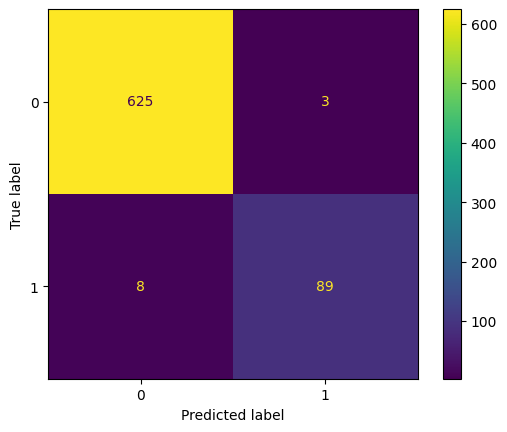

In [29]:

# Créer un DataFrame vide pour stocker les résultats
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])

# Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results_to_df(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Ajouter une nouvelle ligne au DataFrame
    global results_df
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }, ignore_index=True)

model_name = 'Model 1 '
y_true, y_pred = predictions_singleton_to_binary(model_1, 0.5, v2_pad_val, y_val)
add_results_to_df(model_name, y_true, y_pred)
display_matrix_and_scores(y_true, y_pred)
# Afficher le DataFrame
print(results_df)


# modèle 2

 On ajoute une couche Dropout qui est une technique de régularisation qui aide à prévenir le surajustement dans les réseaux de neurones. En l'absence de la couche Dropout, le modèle peut avoir tendance à surapprendre les détails spécifiques du jeu de données d'entraînement, ce qui peut conduire à une performance médiocre sur de nouvelles données (overfitting). La couche Dropout introduit une régularisation en désactivant aléatoirement certains neurones pendant l'entraînement, forçant ainsi le réseau à apprendre de manière plus robuste. Nous allons voir si elle est utile dans notre cas.

In [30]:
model_2 = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [31]:
tensorboard_callback, hparams_callback = compile_and_log(model_2, "Simple Multi-Layers Denses with dropout", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_dense_units':105,
                                                                                            'dropout':0.2})

<keras.src.engine.sequential.Sequential object at 0x7a79228e4d90> logged with name : Simple Multi-Layers Denses with dropout...


In [32]:
model_2.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)

Epoch 1/20
44/44 [==============================] - 5s 38ms/step - loss: 0.5698 - accuracy: 0.7849 - precision: 0.2000 - recall: 0.0254 - val_loss: 0.4685 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 0s 10ms/step - loss: 0.4515 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4382 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 14ms/step - loss: 0.4088 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3812 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.3214 - accuracy: 0.8298 - precision: 0.9457 - recall: 0.1576 - val_loss: 0.2853 - val_accuracy: 0.8770 - val_precision: 0.9318 - val_recall: 0.4184
Epoch 5/20
44/44 [==============================] - 1s 14ms/step - l

23/23 [==============================] - 0s 3ms/step
Accuracy : 0.983448275862069
Precision : 0.9473684210526315
Recall : 0.9278350515463918
      Model  Accuracy  Precision    Recall
0  Model 1   0.984828   0.967391  0.917526
1  Model 2   0.983448   0.947368  0.927835


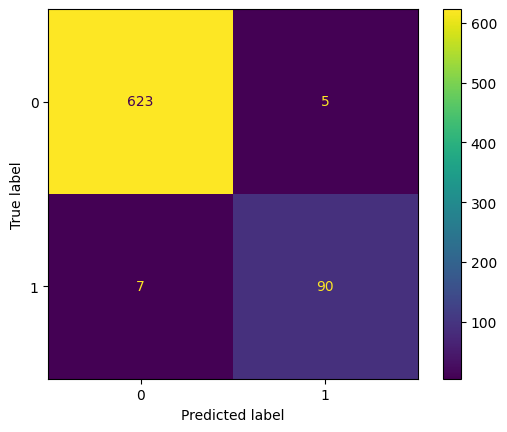

In [33]:
model_name = 'Model 2 '
y_true, y_pred = predictions_singleton_to_binary(model_2, 0.5, v2_pad_val, y_val)
add_results_to_df(model_name, y_true, y_pred)
display_matrix_and_scores(y_true, y_pred)
# Afficher le DataFrame
print(results_df)

# Modèle 3

In [34]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [35]:
tensorboard_callback, hparams_callback = compile_and_log(model_3, "Simple Multi-Layers Denses with dropout", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_dense_units':105,
                                                                                            'dropout':0.2})

<keras.src.engine.sequential.Sequential object at 0x7a7923d8b160> logged with name : Simple Multi-Layers Denses with dropout...


In [36]:
model_3.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)

Epoch 1/20
44/44 [==============================] - 3s 25ms/step - loss: 0.5482 - accuracy: 0.8001 - precision: 0.5000 - recall: 0.0054 - val_loss: 0.4669 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 15ms/step - loss: 0.4518 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4218 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 15ms/step - loss: 0.3519 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2834 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.2248 - accuracy: 0.8755 - precision: 0.9444 - recall: 0.4004 - val_loss: 0.2188 - val_accuracy: 0.9447 - val_precision: 0.9176 - val_recall: 0.7959
Epoch 5/20
44/44 [==============================] - 0s 11ms/step - l

23/23 [==============================] - 0s 3ms/step
Accuracy : 0.9862068965517241
Precision : 0.978021978021978
Recall : 0.9175257731958762
      Model  Accuracy  Precision    Recall
0  Model 1   0.984828   0.967391  0.917526
1  Model 2   0.983448   0.947368  0.927835
2  Model 3   0.986207   0.978022  0.917526


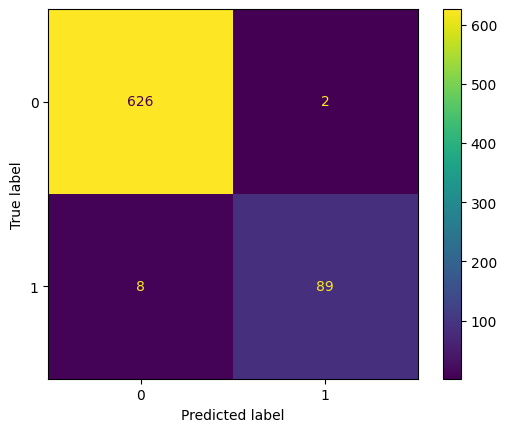

In [37]:
model_name = 'Model 3 '
y_true, y_pred = predictions_singleton_to_binary(model_3, 0.5, v2_pad_val, y_val)
add_results_to_df(model_name, y_true, y_pred)
display_matrix_and_scores(y_true, y_pred)
# Afficher le DataFrame
print(results_df)

Le rappel (recall) est calculé comme le rapport entre le nombre de vrais positifs et la somme des vrais positifs et des faux négatifs. La formule est la suivante :


Recall=
(TP+FN)/TP
​


où TP est le nombre de vrais positifs et FN est le nombre de faux négatifs.

Dans les résultats des trois modèles, le rappel est assez élevé et constant pour tous les modèles, ce qui signifie que le nombre de faux négatifs est relativement constant d'un modèle à l'autre. Cela pourrait indiquer que ces modèles réussissent bien à minimiser le nombre de messages "ham" mal classifiés comme "spam".

 La taille de l'embedding de 128 dans les trois modèles peut être augmentée pour permettre au modèle de capturer des informations plus riches. Nous allons tester un 4e modèles pour tester la couche d'embedding

In [38]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 256, input_shape=[x_train.shape[1],], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [39]:
tensorboard_callback, hparams_callback = compile_and_log(model_4, "Simple Multi-Layers Denses with dropout", {
                                                                                            'dim_embedding':128,
                                                                                            'nb_dense_units':105,
                                                                                            'dropout':0.2})

<keras.src.engine.sequential.Sequential object at 0x7a7923ad94e0> logged with name : Simple Multi-Layers Denses with dropout...


In [40]:
model_4.fit(
    train_batch,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_data=test_batch)

Epoch 1/20
44/44 [==============================] - 3s 34ms/step - loss: 0.5473 - accuracy: 0.7965 - precision: 0.3214 - recall: 0.0163 - val_loss: 0.4704 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 32ms/step - loss: 0.4396 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3972 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 25ms/step - loss: 0.2968 - accuracy: 0.8259 - precision: 0.8901 - recall: 0.1467 - val_loss: 0.2374 - val_accuracy: 0.9303 - val_precision: 0.9211 - val_recall: 0.7143
Epoch 4/20
44/44 [==============================] - 1s 24ms/step - loss: 0.1715 - accuracy: 0.9609 - precision: 0.9370 - recall: 0.8623 - val_loss: 0.1618 - val_accuracy: 0.9488 - val_precision: 0.8763 - val_recall: 0.8673
Epoch 5/20
44/44 [==============================] - 1s 27ms/step - loss: 0.0997 - ac

23/23 [==============================] - 0s 6ms/step
Accuracy : 0.9848275862068966
Precision : 0.9479166666666666
Recall : 0.9381443298969072
      Model  Accuracy  Precision    Recall
0  Model 1   0.984828   0.967391  0.917526
1  Model 2   0.983448   0.947368  0.927835
2  Model 3   0.986207   0.978022  0.917526
3  Model 4   0.984828   0.947917  0.938144


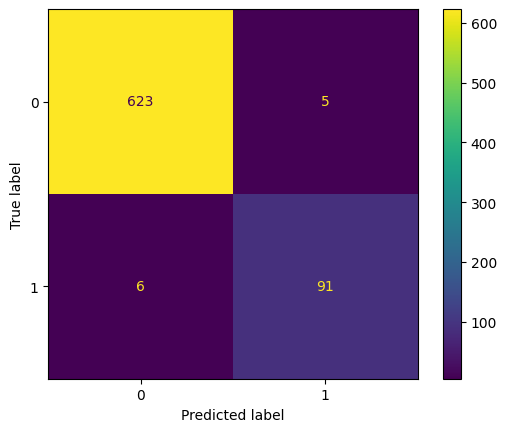

In [41]:
model_name = 'Model 4 '
y_true, y_pred = predictions_singleton_to_binary(model_4, 0.5, v2_pad_val, y_val)
add_results_to_df(model_name, y_true, y_pred)
display_matrix_and_scores(y_true, y_pred)
# Afficher le DataFrame
print(results_df)